In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Linear Regression (1D)
Let's start with linear regression
a simple problem
which means finds the best linear equation that fits to noisy points.

so we have $ (x_i, y_i) $ points, that we assume will fit a linear line $a x + b$

In [39]:
# let's generate a random line
N = 1000
a, b = np.random.uniform(0, 10, 2)

def linear_fun(x, a=a, b=b):
    return a * x + b

x = np.linspace(-50, 50, N)
ideal_line = linear_fun(x)


In [40]:
# and points that should lie on that line
# 3.0 is the std of the noisy points
points = ideal_line + 3.0 * np.random.randn(N)

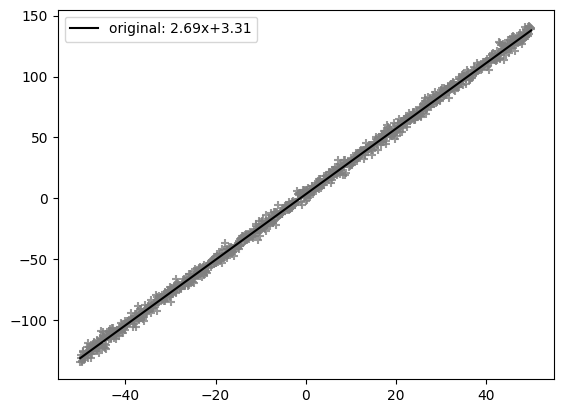

In [41]:
# let's plot that
plt.scatter(x, points, marker='+', color='grey', alpha=0.8)
plt.plot(x, ideal_line, 'k-', label=f'original: {a:.2f}x+{b:.2f}')
plt.legend()

In [42]:
# now let's try to fit a curve to the points
# of course we can use already existing methods:
import scipy.stats as stats
res = stats.linregress(x, points)

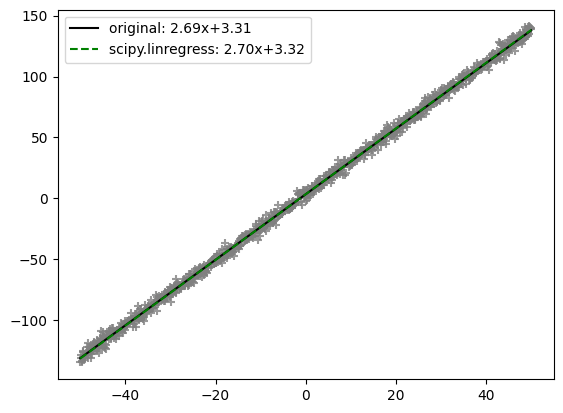

In [43]:
# let's plot that
plt.scatter(x, points, marker='+', color='grey', alpha=0.8)
plt.plot(x, ideal_line, 'k-', label=f'original: {a:.2f}x+{b:.2f}')
plt.plot(x, linear_fun(x, res.slope, res.intercept), 'g--', label=f'scipy.linregress: {res.slope:.2f}x+{res.intercept:.2f}')
plt.legend()

## Remarks 
Notice how this works well, but does not find the exact initial values.
Particularly the intercept... 

if we increase N from 100 -> 1000?
>  we don't necessarily get a better result.

Maybe because we don't have values around those points ? 
> Yes !! that worked by generating points between -50, 50 instead of [0,100]

## now let's do this "manually"

we're going to use gradient descent.
For that we need a cost function

### Cost function

The simplest cost function we can think of is the sum of all errors

$$
J(a, b) = \sum_{i=1}^{N}r_i
$$

Where $r_i$ is the error function
$$
r_i = a x_i + b - y_i
$$

But summing the errors only is problematic because of the sign (imagine half the errors are negative and the other half is positive, then the sum is 0.... ). 
So we sum the square errors, and then a trick is to divide by two (practical when we will derivate later)
$$
J(a, b) = \frac{1}{2} \sum_{i=1}^{N}r_i^2
$$

But then, an issue here is that the cost J will keep increasing naturally the more you have numbers, so to "normalize" it, we divide by $N$

$$
J(a, b) = \frac{1}{2N} \sum_{i=1}^{N}r_i^2
$$

In [155]:
def errors(xi, yi, a, b):
    return linear_fun(xi, a, b) - yi

def cost(xi, yi, a, b, normalize=True):
    n = len(xi) if normalize else 1
    return 0.5 * np.sum(np.square(errors(xi, yi, a, b))) / n

### Jacobians

Gradient descent means we need to compute the derivative of the cost function relative to all variables, in our case $a$ and $b$

$$
\frac{\partial J(a,b)}{\partial a} = \sum_{i=1}^{N}{r_i x_i}
$$

$$
\frac{\partial J(a,b)}{\partial b} = \sum_{i=1}^{N}{r_i}
$$

In [197]:
def jacob(xi, yi, a, b, normalize=True):
    n = len(xi) if normalize else 1
    e = errors(xi, yi, a, b)
    dJda = e @ xi / n
    dJdb = np.sum(e) / n
    return dJda, dJdb

### Algorithm

Now that we have computed the gradient, we need a step by step instructions to apply the gradient descent.

In [198]:
# First we need a first guess for a and b
a_guess, b_guess = 1, 0

# Then let's compute what the function would be if we used those guess
guess_0 = linear_fun(x, a_guess, b_guess)

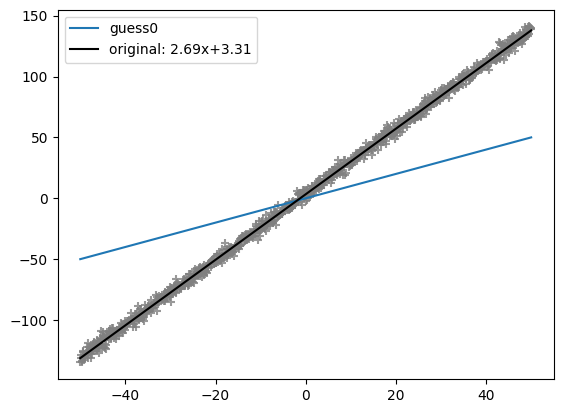

In [199]:
plt.plot(x, guess_0, label='guess0')
plt.scatter(x, points, marker='+', color='grey', alpha=0.8)
plt.plot(x, ideal_line, 'k-', label=f'original: {a:.2f}x+{b:.2f}')
plt.legend()

In [200]:
# This is not a good guess, but let's compute the cost to see how much
cost(x, points, a_guess, b_guess)

np.float64(1213.3896256279572)

In [201]:
# let's see what the jacobians tells us
jacob(x, points, a_guess, b_guess)

(np.float64(-1417.522342583128), np.float64(-3.319691610078604))

In [202]:
# We can update the guesses for a and b with those jacobians
# enter gradient descent update part!
# we need and alpha (learning rate)
alpha = 0.01

dJda, dJdb = jacob(x, points, a_guess, b_guess)
a_1 = a_guess - alpha * dJda
b_1 = b_guess - alpha * dJdb

# what's the new cost?
cost(x, points, a_1, b_1)

np.float64(65010.93212538768)

In [203]:
a_1, b_1

(np.float64(15.17522342583128), np.float64(0.03319691610078604))

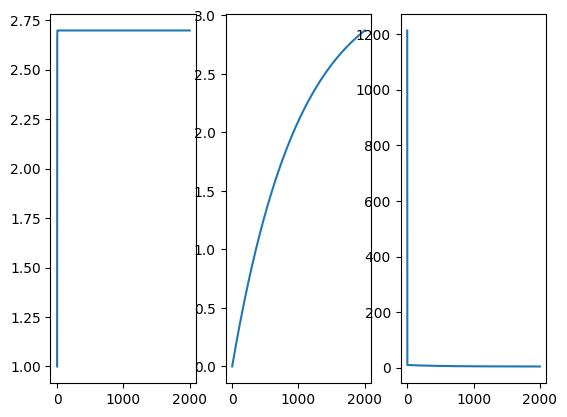

In [209]:
# Note, we see that choosing a relatively big alpha will drastically change a and b
# which can lead to divergence.
# For example here, if you set alpha to 1e-2, values explode
# But a value of 1e-3 is fine... but too slow...

a_g = a_guess
b_g = b_guess
a_guesses = [a_g]
b_guesses = [b_g]
costs = [cost(x, points, a_g, b_g)]

alpha = 1e-3

for i in range(2000):
    dJda, dJdb = jacob(x, points, a_g, b_g)
    a_g = a_g - alpha * dJda
    b_g = b_g - alpha * dJdb
    a_guesses.append(a_g)
    b_guesses.append(b_g)
    costs.append(cost(x, points, a_g, b_g))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(a_guesses)
ax2.plot(b_guesses)
ax3.plot(costs)

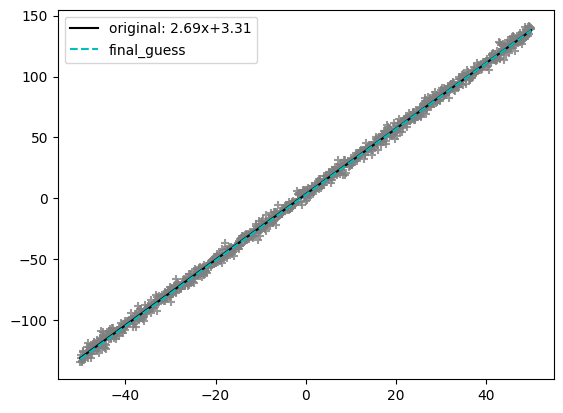

In [210]:
plt.scatter(x, points, marker='+', color='grey', alpha=0.8)
plt.plot(x, ideal_line, 'k-', label=f'original: {a:.2f}x+{b:.2f}')
plt.plot(x, linear_fun(x, a_g, b_g), 'c--', label='final_guess')
plt.legend()

### Finding a good learning rate

manual search of the learning rate here can be annoying... you need to adjust the learning rate until you found one that solves your problem.

#### Hessian

One solution is to take the second derivative of the cost error, and therefore adjust the learning rate accordingly:

$$
H|_aa = \frac {\partial^2 J} {\partial a^2} = \frac{1}{N} \sum_i x_i^2
$$
$$
H|_ba = \frac {\partial^2 J} {\partial b \partial a} = \frac{1}{N} \sum_i xi
$$
$$
H|_ab = \frac {\partial^2 J} {\partial a \partial b} = \frac{1}{N} \sum_i xi
$$
$$
H|_bb = \frac {\partial^2 J} {\partial b^2} = \frac{1}{N} \sum_i 1 = 1
$$

$$
H = \frac{1}{N} \begin{pmatrix} \sum_i x_i^2 & \sum_i xi \\ \sum_i xi & N \end{pmatrix}
$$

And then the learning rate is simply: $H^{-1}$



In [211]:
def h(xi, normalize=True):
    n = len(xi) if normalize else 1
    xi2 = np.sum(np.square(xi))
    xi = np.sum(xi)
    return np.array([[xi2, xi], [xi, n]]) / n

In [212]:
h(x)

array([[8.35001668e+02, 3.63797881e-15],
       [3.63797881e-15, 1.00000000e+00]])

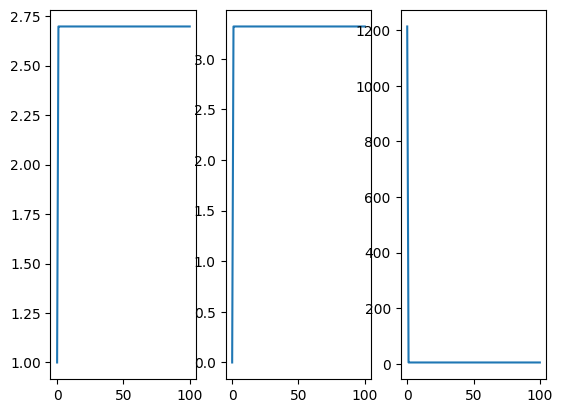

In [226]:
# let's try with the hessian as a learning rate, which is different for a and b

theta = np.array([a_guess, b_guess]).reshape(2,1)
guesses = [theta]
costs = [cost(x, points, theta[0], theta[1])]
alpha_hessian = np.linalg.inv(h(x))

for i in range(100):
    dJda, dJdb = jacob(x, points, theta[0], theta[1])
    dj = np.array([dJda, dJdb]).reshape(2, 1)
    theta = theta - alpha_hessian @ dj
    guesses.append(theta)
    costs.append(cost(x, points, theta[0], theta[1]))

guesses = np.array(guesses).reshape(-1, 2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(guesses[:, 0])
ax2.plot(guesses[:, 1])
ax3.plot(costs)

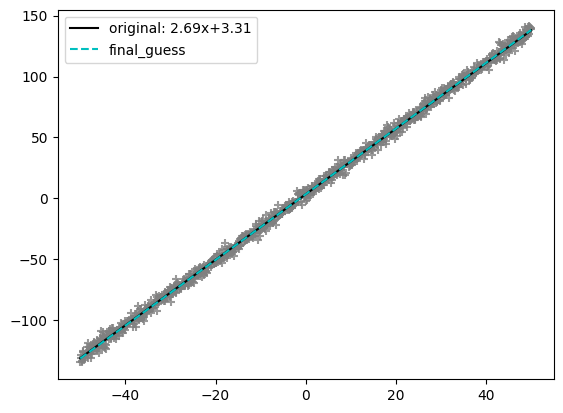

In [227]:
plt.scatter(x, points, marker='+', color='grey', alpha=0.8)
plt.plot(x, ideal_line, 'k-', label=f'original: {a:.2f}x+{b:.2f}')
plt.plot(x, linear_fun(x, theta[0], theta[1]), 'c--', label='final_guess')
plt.legend()

This works wonderfully !! and in only 1 iteration !!! (this is the newton method)